In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.python.ops import rnn, rnn_cell
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import datetime
from statsmodels.tsa.arima_model import ARIMA

import keras
from keras.layers import Dense, Input, Permute, concatenate, BatchNormalization, Activation,GlobalMaxPooling1D, GlobalAveragePooling1D, Bidirectional
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D, AveragePooling1D
from keras.layers import Dropout
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

Using TensorFlow backend.


In [3]:
f = open('data.csv','rU')
entries_all = pd.read_csv(f, parse_dates=[[3,4]])
entries_all["Hour"]=pd.DatetimeIndex(entries_all["Time_EventDateTime"]).hour   #Include hour as a feature
entries_all["Total_insulin"]=entries_all["Insulin_Basal"]+entries_all["Insulin_bolus"]
print(entries_all.shape)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/dateutil/parser/_parser.py:1204: UnknownTimezoneWarning: tzname T identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


(34848, 11)


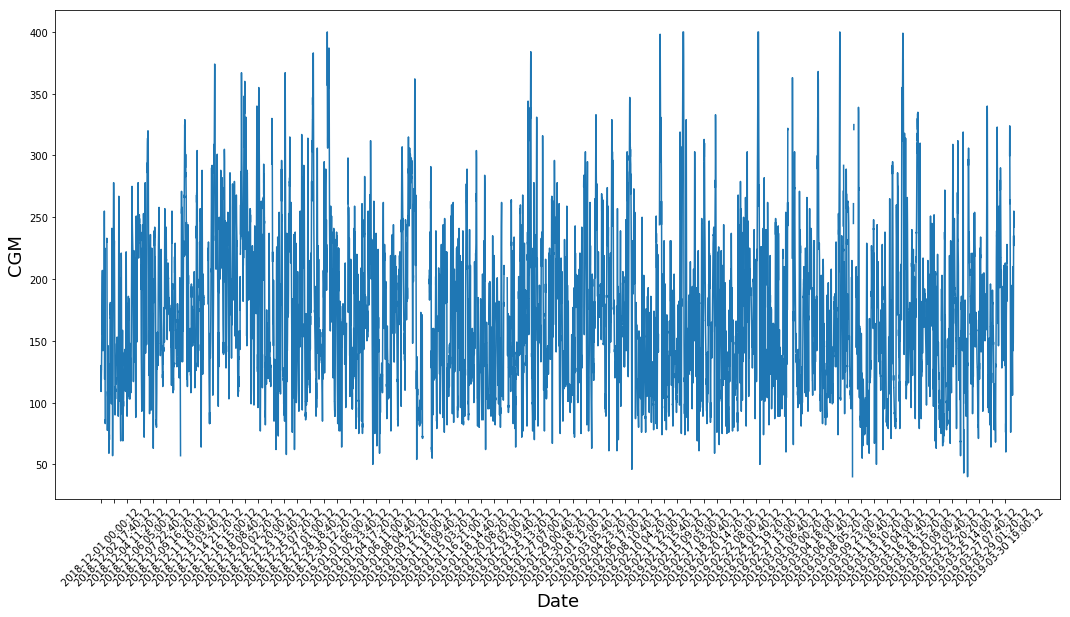

In [5]:
plt.figure(figsize = (18,9))
plt.plot(range(entries_all.shape[0]),entries_all['CGM'])
plt.xticks(range(0,entries_all.shape[0],500),entries_all['Time_EventDateTime'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('CGM',fontsize=18)
plt.show()

Generate dataset

In [4]:
# convert series to supervised learning
def series_to_supervised(data,labels, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, -1, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (labels[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    cols.append(df.shift(-n_out))
    names += [('%s(t+%d)' % (labels[j], n_out)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
time_steps = 36 #3 hours

percenttrain = 0.85

entries_train = entries_all[:(int(.85*entries_all.shape[0]))] #train data
entries_test = entries_all[(int(.85*entries_all.shape[0])):] #test data

labels_original = ["CGM","Insulin_Basal","Insulin_bolus","Hour","Carbs","Total_insulin"]
labels = ["CGM_scaled","Basal_scaled","Bolus_scaled","Hour_scaled","Carbs_scaled","Total_insulin_scaled"]
features = [0,3,4,5]
n_features = len(features)
scaler = {}

if(n_features==1):

    for l in features:
        scaler[labels[l]]=StandardScaler()
        #scaler[labels[l]]=MinMaxScaler()


    #For training data
    null_index = entries_train['CGM'].isnull()
    entries_train.loc[~null_index, 'CGM_scaled'] = scaler["CGM_scaled"].fit_transform(entries_train.loc[~null_index, 'CGM'].values.reshape(-1, 1))

    data_train = series_to_supervised(entries_train[[labels[i] for i in features]],[labels[i] for i in features],time_steps,6).values
    np.random.shuffle(data_train)

    #for test data
    null_index = entries_test['CGM'].isnull()
    entries_test.loc[~null_index, 'CGM_scaled'] = scaler["CGM_scaled"].transform(entries_test.loc[~null_index, 'CGM'].values.reshape(-1, 1))
    
    data_test = series_to_supervised(entries_test[[labels[i] for i in features]],[labels[i] for i in features],time_steps,6).values
else:
    for l in features:
        scaler[labels[l]]=StandardScaler()
        #scaler[labels[l]]=MinMaxScaler()

    #For training data
    null_index = entries_train['CGM'].isnull()
    entries_train.loc[~null_index, 'CGM_scaled'] = scaler["CGM_scaled"].fit_transform(entries_train.loc[~null_index, 'CGM'].values.reshape(-1, 1))

    for i in features[1:]:
        entries_train[labels[i]] = scaler[labels[i]].fit_transform(entries_train[labels_original[i]].values.reshape(-1, 1))

    data_train = series_to_supervised(entries_train[[labels[i] for i in features]],[labels[i] for i in features],time_steps,6).values
    np.random.shuffle(data_train)

    #For test data
    null_index = entries_test['CGM'].isnull()
    entries_test.loc[~null_index, 'CGM_scaled'] = scaler["CGM_scaled"].transform(entries_test.loc[~null_index, 'CGM'].values.reshape(-1, 1))

    for i in features[1:]:
        entries_test[labels[i]] = scaler[labels[i]].transform(entries_test[labels_original[i]].values.reshape(-1, 1))

    data_test = series_to_supervised(entries_test[[labels[i] for i in features]],[labels[i] for i in features],time_steps,6).values



train_X, train_y = data_train[:, :time_steps*n_features], data_train[:, -n_features]
test_X, test_y = data_test[:, :time_steps*n_features], data_test[:, -n_features]

print([labels[i] for i in features])


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardSca

['CGM_scaled', 'Hour_scaled', 'Carbs_scaled', 'Total_insulin_scaled']


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 23186 samples, validate on 4092 samples
Epoch 1/400
 - 4s - loss: 0.9210 - val_loss: 0.8375
Epoch 2/400
 - 2s - loss: 0.7530 - val_loss: 0.6892
Epoch 3/400
 - 2s - loss: 0.6182 - val_loss: 0.5777
Epoch 4/400
 - 2s - loss: 0.5331 - val_loss: 0.5344
Epoch 5/400
 - 2s - loss: 0.5134 - val_loss: 0.5288
Epoch 6/400
 - 2s - loss: 0.5004 - val_loss: 0.5034
Epoch 7/400
 - 2s - loss: 0.4767 - val_loss: 0.4857
Epoch 8/400
 - 2s - loss: 0.4622 - val_loss: 0.4735
Epoch 9/400
 - 2s - loss: 0.4498 - val_loss: 0.4585
Epoch 10/400
 - 2s - loss: 0.4347 - val_loss: 0.4429
Epoch 11/400
 - 2s - loss: 0.4217 - val_loss: 0.4277
Epoch 12/400
 - 2s - loss: 0.4083 - val_loss: 0.4122
Epoch 13/400
 - 2s - loss: 0.3932 - val_loss: 0.3974
Epoch 14/400
 - 2s - loss: 0.3799 - val_loss: 0.3836
Epoch 15/400
 - 2s - loss: 0.3680 - val_loss: 0.3722
Epoch 16/400
 - 2s - loss: 0.3595 - val_loss: 0.3636
Epoch 17/400
 - 2s - loss: 0.3521 - val_loss: 0.3564
Epoch 18/400
 - 2s - loss: 0.3454 - val_loss: 0.3502
Epoch 

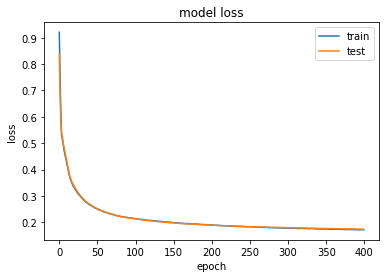

In [17]:
K.clear_session()
train_X = train_X.reshape((train_X.shape[0], time_steps, n_features))

if True:
    model = Sequential()
    model.add(LSTM(128,return_sequences=True))
    model.add(LSTM(128))
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(Dense(32))
    model.add(Dense(1))
#    model.summary()


#model = generate_lstmfcn(n_features, time_steps)
#model = generate_crn(n_features, time_steps)
#model = generate_dnn(n_features, time_steps)

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001))


# fit network
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, mode='auto', factor=(1. / np.cbrt(2)), cooldown=0, min_lr=1e-6, verbose=2)
history = model.fit(train_X, train_y, epochs=400, batch_size=4096, validation_split=0.15, verbose=2, shuffle=False, callbacks=[reduce_lr])
dt = datetime.datetime.now()
# serialize model to JSON
model_json = model.to_json()
with open("model5%s.json" % dt, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model5%s.h5" % dt)
print("Saved model to disk")

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Test RMSE: 24.578


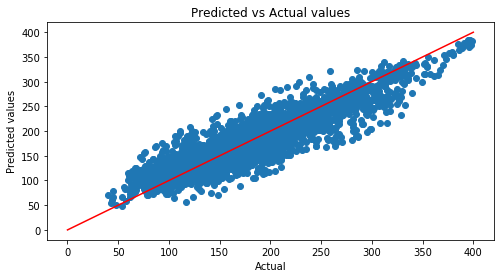

In [33]:
# make a prediction with the LSTM model
test_X = test_X.reshape((test_X.shape[0], time_steps, n_features))
yhat = model.predict(test_X)
test_X2 = test_X.reshape((test_X.shape[0], time_steps*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X2[:, -(n_features-1):]), axis=1)
inv_yhat = scaler["CGM_scaled"].inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y2 = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y2, test_X2[:, -(n_features-1):]), axis=1)
inv_y = scaler["CGM_scaled"].inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

errors = inv_y-inv_yhat

plt.figure(figsize = (8,4))
plt.scatter(inv_y,inv_yhat)
plt.plot([0,400],[0,400], color="red")
plt.title('Predicted vs Actual values')
plt.ylabel('Predicted values')
plt.xlabel('Actual')
plt.show()

Test RMSE: 32.117


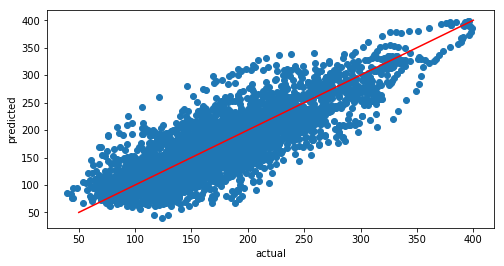

In [16]:
# make a NAIVE prediction

# invert scaling for forecast
inv_yhat_naive = scaler["CGM_scaled"].inverse_transform(data_test[:, :time_steps*n_features][:,(time_steps*n_features)-n_features])
# invert scaling for actual
test_y2 = test_y.reshape((len(test_y), 1))
inv_y = scaler["CGM_scaled"].inverse_transform(test_y2)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat_naive))
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize = (8,4))
plt.scatter(inv_y,inv_yhat_naive)
plt.plot([50,400],[50,400], color="red")
#plt.title('model loss')
plt.ylabel('predicted')
plt.xlabel('actual')
plt.show()

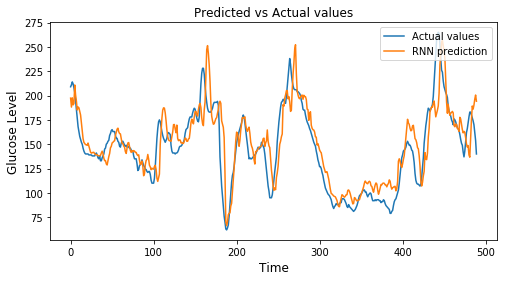

In [34]:
plt.figure(figsize = (8,4))
p = 0.1
plt.plot(range(int(inv_y.shape[0]*p)),inv_y[0:int(inv_y.shape[0]*p)])
plt.plot(range(int(inv_yhat.shape[0]*p)),inv_yhat[0:int(inv_yhat.shape[0]*p)])
#plt.plot(range(int(inv_yhat_naive.shape[0]*p)),inv_yhat_naive[0:int(inv_yhat_naive.shape[0]*p)])
plt.title('Predicted vs Actual values')
plt.xlabel('Time',fontsize=12)
plt.ylabel('Glucose Level',fontsize=12)
plt.legend(['Actual values', 'RNN prediction'], loc='upper right')
plt.show()

In [5]:
#Ideas from: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8141873    https://github.com/titu1994/LSTM-FCN
def generate_lstmfcn(NUM_FEATURES, MAX_SEQUENCE_LENGTH):
    
    ip = Input(shape=(MAX_SEQUENCE_LENGTH,NUM_FEATURES))
    y = Conv1D(128, 8, padding='same')(ip)
    y = BatchNormalization()(y)
    y = Activation('tanh')(y)
    y = Dropout(0.8)(y)
    y = Conv1D(256, 5, padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('tanh')(y)
    y = Dropout(0.8)(y)
    y = Conv1D(64, 3, padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('tanh')(y)
    y = Dropout(0.8)(y)
    y = AveragePooling1D()(y)
    y = LSTM(64)(y)
    y = Dropout(0.8)(y)    
    y = Dense(64)(y)
    y = Dropout(0.8)(y)
    out = Dense(1)(y)
    

    model = Model(ip, out)

    model.summary()

    return model

In [6]:
#Ideas from: https://arxiv.org/pdf/1807.03043.pdf
def generate_crn(NUM_FEATURES, MAX_SEQUENCE_LENGTH):
    
    ip = Input(shape=(MAX_SEQUENCE_LENGTH,NUM_FEATURES))
   
    y = Conv1D(8, 4, padding='same')(ip)
    y = Activation('relu')(y)
    y = MaxPooling1D(pool_size=(2))(y) 
    y = Conv1D(16, 4, padding='same')(ip)
    y = Activation('relu')(y)
    y = MaxPooling1D(pool_size=(2))(y)
    y = Conv1D(16, 4, padding='same')(ip)
    y = Activation('relu')(y)
    y = MaxPooling1D(pool_size=(2))(y)
    y = Conv1D(32, 4, padding='same')(ip)
    y = Activation('relu')(y)
    y = MaxPooling1D()(y)
    y = LSTM(128,return_sequences=True)(y)
    y = Dropout(0.8)(y)   
    y = LSTM(128)(y)
    y = Dropout(0.8)(y)   
    y = Dense(256,kernel_regularizer=regularizers.l2(0.01))(y)
    y = Dropout(0.8)(y)
    y = Dense(32)(y)
    y = Dropout(0.8)(y)
    out = Dense(1)(y)
    
    model = Model(ip, out)

    model.summary()

    return model

In [7]:
#Ideas from: 
def generate_dnn(NUM_FEATURES, MAX_SEQUENCE_LENGTH):
    drop = 0.5
    
    ip = Input(shape=(MAX_SEQUENCE_LENGTH,NUM_FEATURES)) 
    y = Dense(512)(ip)
    y = Activation('tanh')(y)
    y = BatchNormalization()(y)
    y = Dropout(drop)(y)
    y = Dense(256)(y)
    y = Activation('tanh')(y)
    y = BatchNormalization()(y)
    y = Dropout(drop)(y)
    y = Dense(128)(y)
    y = Activation('tanh')(y)
    y = BatchNormalization()(y)
    y = Dropout(drop)(y)
    y = Dense(64)(y)
    y = Activation('tanh')(y)
    y = BatchNormalization()(y)
    y = Dropout(drop)(y)
    y = Dense(32)(y)
    y = Activation('tanh')(y)
    y = BatchNormalization()(y)
    y = Dropout(drop)(y)
    y = Flatten()(y)
    out = Dense(1, activation='tanh')(y)
    
    model = Model(ip, out)

    model.summary()

    return model